---
authors: Chinming Zhu
---

# Thermostaat

In het vorige werkblad heb je gezien hoe een gas zich gedraagt in een zuiger waarbinnen wordt voldaan aan de wet van behoud van energie.
In dat geval geldt $p \propto \alpha V^{-k}$, waarbij $k$ een exponent is die wordt bepaald door de vrijheidsgraden van het gas - in onze simulatie werken we met mono-atomaire gassen in 2D. 

We hadden kunnen denken dat we de ideale gaswet zouden kunnen gebruiken.
Echter, de temperatuur van het gas verandert door de werking van de zuiger - deze verricht arbeid. 

Het meenemen van arbeid dat verricht wordt door, of op, het gas is een eerste uitbreiding die belangrijk is in Thermodynamica.
Uitwisseling van energie (toevoegen of afvoeren van warmte) is een tweede uitbreiding.
In deze simulatie onderzoeken we die uitbreiding waarbij we warmte aan en af voeren uit het controlevolume.
Op die manier kunnen we ook isotherme simulaties doen.

Eerst herhalen we de nodige ingrediënten:

- klasse voor het deeltje met bijbehorende functies
- variabelen en randcondities van controle volume
- functies voor een lijst deeltjes

Daarna voegen we de code toe voor het warmtecontact:

- introduceren thermostaat

En vervolgens
- bestuderen isotherm proces

## Laden van eerdere code

De pakketten van Python en de constanten voor de simulatie:

```{exercise} constanten
:label: ex-thermostat-01
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over.
```


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit

FAST_MODE = True  # Zet op False voor de volledige (langzamere) simulatie
FAST_MAX_STEPS = 2500  # algemene cap voor lange loops (snelle modus)


# ----------------------------
# Constanten (zelfde orde van grootte als eerdere werkbladen)
# ----------------------------
k_B = 1.38e-23                 # J/K
MASS = 4.65e-26                # kg (orde van grootte luchtmolecuul)
T0 = 300                       # K (starttemperatuur)

BOX_SIZE_0 = 20e-9             # m  (hoogte en lengte startvolume)
N = 30 if FAST_MODE else 40
RADIUS = 0.05e-9               # m  (diameter 0.1 nm)

# Startsnelheid: kies V_0 zodat de starttemperatuur ongeveer T0 is
V_0 = np.sqrt(2 * k_B * T0 / MASS)

# Tijdstap (klein genoeg zodat botsingen niet "overgeslagen" worden)
DT = 1.0e-13                   # s

# Startsnelheid van zuiger (negatief betekent zowel links als rechts naar binnen)
V_PISTON_0 = (-0.2 if FAST_MODE else -0.1) * V_0

De klasse voor het gasmolecuul met de interacties:

In [2]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    return np.linalg.norm(p1.r - p2.r) < (p1.R + p2.R)


def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

De randvoorwaarde van het volume. Hierbij is rekening gehouden met een bewegende zuiger die in het vorige werkblad is toegevoegd.

In [3]:
def top_down_collision(particle: ParticleClass):
    global impulse_outward, box_height
    if abs(particle.r[1]) + particle.R > box_height / 2:
        particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * 2
        particle.v[1] *= -1

def left_right_collision(particle: ParticleClass):
    """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
    global box_length, v_piston, impulse_outward, work
    if abs(particle.r[0]) + particle.R > box_length / 2:
        particle.r[0] = np.sign(particle.r[0]) * (box_length/2 - particle.R)
        piston_velocity = np.sign(particle.r[0]) * v_piston
        relative_velocity = particle.v[0] - piston_velocity  # stelsel zuiger
        particle.v[0] = -relative_velocity + piston_velocity # stelsel waarnemer
        impulse_outward += 2 * particle.m * abs(relative_velocity)
        work += 2 * particle.m * relative_velocity * piston_velocity

De functies voor het uitvoeren van de functies over de gehele lijst met deeltjes, waarbij we de werking van de zuiger ook hebben meegenomen:

```{exercise} temperatuur
:label: ex-thermostat-02
Pas de code voor de functie `temperature` aan naar de functie die je op de vorige werkbladen hebt gebruikt.
```

In [4]:
def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    global box_length, box_height
    particles.clear()
    for _ in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        x = np.random.uniform(-box_length/2 + RADIUS, box_length/2 - RADIUS)
        y = np.random.uniform(-box_height/2 + RADIUS, box_height/2 - RADIUS)
        particles.append(ParticleClass(m=MASS, v=[vx, vy], r=[x, y], R=RADIUS))
    
def temperature(particles) -> float:
    # In 2D geldt per deeltje: <E_kin> = k_B T
    if len(particles) == 0:
        return 0.0
    total_ke = 0.0
    for p in particles:
        total_ke += p.kin_energy
    temp = total_ke / (len(particles) * k_B)
    return temp
        
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward, box_height, box_length   # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    pressure = 0.95 * pressure + 0.05 * impulse_outward / ((2 * box_length + 2 * box_height) * DT) 
    
def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    global box_length, v_piston
    box_length += 2 * v_piston * DT # zowel links als rechts zuiger
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  


## Test code

Voordat we de code aanpassen controleren we eerst of alles het doet. Hiervoor maken we zowel een $P,V$-diagram als een $T,V$-diagram (met als toevoeging een $P,T$-diagram) tijdens de werking van de zuiger. Let op! De eenheden van deze grafiek kunnen niet kloppen omdat er niet in verrekend zit welke constanten jij hebt gekozen. 

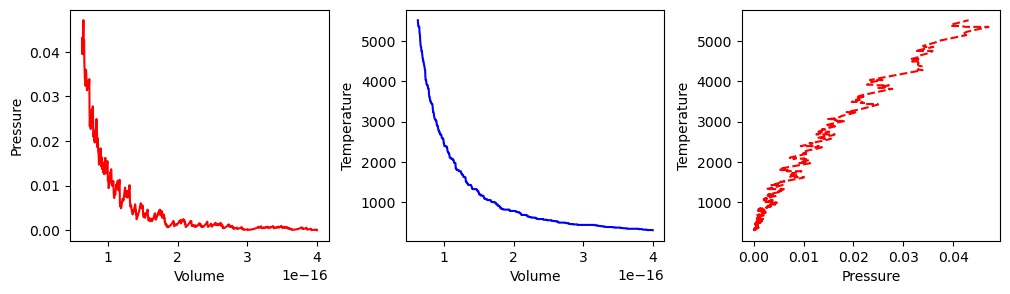

In [5]:
particles = []
volumes = np.zeros(1000, dtype=float)
pressures = np.zeros(1000, dtype=float)
temperatures = np.zeros(1000, dtype=float)
# times = np.linspace(1, 100, 100)

pressure = 0.0
work = 0.0
box_height = BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0
create_particles(particles)     # resetten deeltjes 
for i in range(1000):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    temperatures[i] = temperature(particles)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
ax3.set_xlabel('Pressure')
ax3.set_ylabel('Temperature')

fig.tight_layout

ax1.plot(volumes, pressures, '-r')
ax2.plot(volumes, temperatures, '-b')
ax3.plot(pressures, temperatures, 'r--')
plt.subplots_adjust(wspace=0.3)      # afstand tussen subplots
plt.show()

We zien inderdaad de druk, $P \propto V^{-k}$, met een exponent $k > 1$, wat verklaard wordt door de toename van de temperatuur tijdens het proces. 

Maar wat gebeurt er wanneer we de temperatuur van het gas constant houden? Als we dat doen kunnen we controleren of de druk inderdaad invers proportioneel is met het volume, zoals de gaswet voorschrijft. 

## De thermostaat

In de werkelijkheid is de temperatuur van de wand een mate van de amplitude van de trillingen van de deeltjes waaruit de wand bestaat.
De wederzijdse overdracht van de energie van die trillingen naar de kinetische energie van de gasmoleculen bepaalt het thermische contact tussen de wanden van het volume en het gas.
In ons model bestaat de wand echter helemaal niet uit deeltjes maar hebben we een denkbeeldige lijn getrokken in de ruimte.
We moeten daarom een wiskundige truc toepassen om de temperatuur van het gas te beïnvloeden. 

Er zijn in de literatuur verschillende van dit soort trucs bedacht.
Ze worden een 'thermostaat' genoemd.
Elk van die type trucs hebben hun voor- en nadelen.
In ons geval houden we het simpel: Op het moment dat een gasmolecuul botst met de wand (die een thermisch contact voorstelt), dan schalen we de snelheid van dit molecuul met (de wortel van) de verhouding tussen de veronderstelde temperatuur van de wand en de temperatuur die het gas op dat moment heeft:

$$
  v = \sqrt{ \frac{T_{wand}} {T_{deeltje}} }v
$$

Voor het gemak houden we de linker en rechter wand van het volume als zuiger en maken we het thermische contact aan de onder- en bovenwand.

In [6]:
def top_down_collision(particle: ParticleClass) -> None:
    """ verzorgen van botsingen met wand boven en onder, die als thermostaat kunnen werken """
    global box_height, set_temp, impulse_outward, heat
    if abs(particle.r[1]) + particle.R > box_height / 2:
        # temp_factor bepaalt hoeveel we de snelheid moeten schalen om richting T_wand te gaan
        temp_factor = (set_temp/temperature(particles)) if set_temp > 0 else 1.0

        # zet het deeltje precies op de wand zodat het niet 'vast' buiten het volume blijft hangen
        particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)

        # impuls op de wand: door botsing keert p_y om, en door de thermostat-schaling verandert |p| ook
        impulse_outward += abs(particle.momentum[1]) * (1 + temp_factor**0.5)

        # warmteboekhouding: verandering van kinetische energie door het schalen tellen we als Q
        heat += particle.kin_energy * (temp_factor - 1)

        # schaal de snelheid zodat de kinetische energie (gemiddeld) overeenkomt met T_wand
        particle.v *= temp_factor**0.5

        # elastische botsing met de wand: alleen de y-component keert om
        particle.v[1] *= -1


```{exercise} uitleg thermostaat
:label: ex-thermostat-03
Leg bij elke regel na het eerste if-statement uit (in een enkele zin) waarom deze regel zo is gecodeerd. 
Leg de regels hieronder uit, maar voeg ook comments toe in bovenstaande code. 
```

```{solution} ex-thermostat-03
- `temp_factor = (set_temp/temperature(particles)) ...` berekent hoeveel het deeltje (en daarmee het gas) relatief “te warm/te koud” is t.o.v. de wandtemperatuur.
- `particle.r[1] = ...` zet het deeltje terug precies binnen de rand zodat het niet buiten het beheersvolume blijft.
- `impulse_outward += ...` telt de impulsverandering op om later de druk via $\Delta p/\Delta t$ te bepalen; door het schalen verandert de impuls ook.
- `heat += particle.kin_energy * (temp_factor - 1)` boekt de energieverandering door het schalen als warmte $Q$ (positief = warmte naar het gas).
- `particle.v *= temp_factor**0.5` schaalt de snelheid met $\sqrt{T_{wand}/T_{gas}}$ zodat de kinetische energie en dus de temperatuur naar $T_{wand}$ toe gaat.
- `particle.v[1] *= -1` laat het deeltje elastisch terugkaatsen op de wand (alleen de component loodrecht op de wand keert om).
```


Met deze nieuwe definitie van de functies, draaien we een simulatie waarin we zowel de temperatuur als de druk plotten als functie van het volume.

```{warning}
Deze simulatie bevat vanwege de tragere zuiger een veel groter aantal tijdstappen .
Daarom zal deze simulatie ook langer duren.
Maak je geen zorgen als het een minuut duurt om de berekening te voltooien.
```

Om verdere belasting van de processor tot een minimum te beperken, berekent deze simulatie ook alvast de totale warmte $Q$ en de totale arbeid $W$ tijdens het proces.
Deze worden opgeslagen in de arrays `heats` en `works`.
We zullen de resultaten van deze simulatie voor een aantal vervolgstappen gebruiken. 

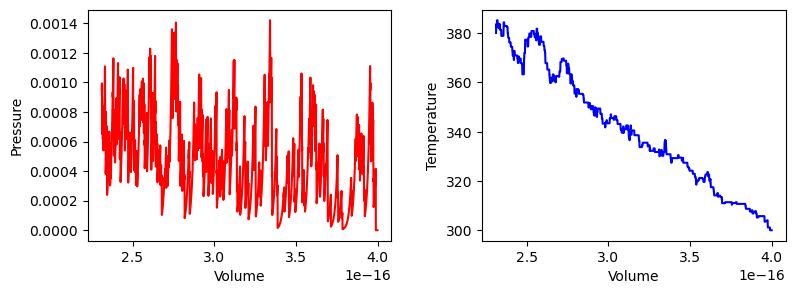

In [7]:
particles = []
N_steps = 2500 if FAST_MODE else 5000
volumes = np.zeros(N_steps, dtype=float)
pressures = np.zeros(N_steps, dtype=float)
temperatures = np.zeros(N_steps, dtype=float)
heats = np.zeros(N_steps, dtype=float)
works = np.zeros(N_steps, dtype=float)

pressure = 0.0
work = 0.0
heat = 0.0
box_height = BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = 0.2 * V_PISTON_0
create_particles(particles)     # resetten deeltjes 
set_temp = temperature(particles)

for i in range(N_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    temperatures[i] = temperature(particles)
    heats[i] = heat
    works[i] = work
    if (not FAST_MODE) and i%500==0:
        print(i)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
fig.tight_layout

ax1.plot(volumes, pressures, '-r')
ax2.plot(volumes, temperatures, '-b')

plt.subplots_adjust(wspace=0.3)   
plt.show()

```{exercise} fit P,V-diagram
:label: ex-thermostat-04
Maak een fit van het $(P,V)$-diagram uit de laatste simulatie.
(Maak dus niet een nieuwe simulatie, maar gebruik de gegevens van de vorige) De fit-functie hiervoor is alvast gegeven.
De correcte parameters die uit deze fit volgen zijn sterk afhankelijk van de constanten die je aan de start van dit werkblad gekozen hebt.
Je moet dus actief moeten zoeken naar de juiste startwaarden voor de fit om een werkbaar antwoord te krijgen.
Maak daarom weer gebruik van van de extra optie `p0=` in de argumenten van de functie `curve_fit`.
```

````{tip}
:class: dropdown
Het zelfstandig afschatten van `p0` is lastig, maar omdat de relatie tussen $p$ en $V$ bekend is, kunnen we wel een eerste stap maken door twee van onze metingen te nemen ($p_0$ en $p_1$ en $V_0$ en $V_1$), delen we die waarden door elkaar en nemen we links en rechts de logaritme krijgen we:

$$
  log(\frac{p_0}{p_1})=log(\frac{V_0}{V_1})(-n)
$$

Zo hebben we een schatting ($n_{init}$) voor $n$ gevonden. Door die waarde nu te substitueren vinden we een initiele guess ($a_{init}$) voor de waarde van $a$:

$$
  a = p_0V_0^{n_{init}}
$$

Let op het - teken!
Waar we nog verder rekening mee moeten houden is dat een verkeerde waarde voor $n_{init}$ kan zorgen voor hele grote fouten in $a_{init}$ omdat die exponentieel mee telt.
Omdat $p$ en $V$ fluctueren door het gering aantal deeltjes kunnen we beter waarden voor sampelen waarbij we een keuze maken moeten tussen grotere sample size voor reduceren van ruis en kleine sampele size om het effect van de zuiger klein te houden:

```python
p0 = np.mean(pressures[100:110])
p1 = np.mean(pressures[N:N+10])
V0 = np.mean(volumes[100:110])
V1 = np.mean(volumes[N:N+10])

n_init = -np.log(p0/p1) / np.log(V0/V1)
a_init = p0 * V0**(-n_init)
```
```` 

In [8]:
p0 = np.mean(pressures[100:110])
p1 = np.mean(pressures[-10:])
V0 = np.mean(volumes[100:110])
V1 = np.mean(volumes[-10:])

n_init = -np.log(p0/p1) / np.log(V0/V1)
a_init = p0 * V0**(-n_init)
print(n_init)
print(a_init)


2.973111458870162
1.042405321477611e+42


a = 1.276e-30 ± 3.387e-30
n = -1.712 ± 0.074


C:\Users\zhuch\AppData\Local\Temp\ipykernel_18132\720996476.py:2: RuntimeWarning: overflow encountered in power
  return a * vol**n


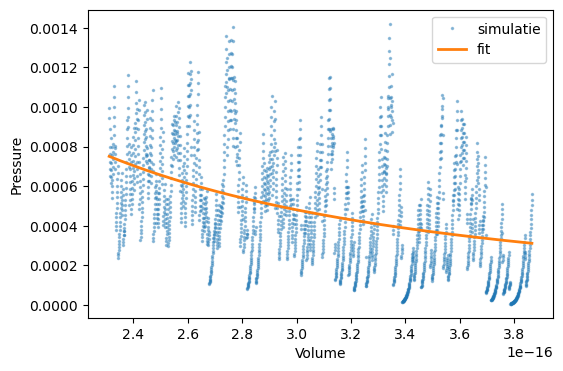

In [9]:
def power_law(vol, a, n):
    return a * vol**n

# Fit (P,V) uit de vorige simulatie: P = a V^n
fit_start = 200  # eerste stappen zijn vaak transiënt
V_fit = volumes[fit_start:]
P_fit = pressures[fit_start:]

# Alleen positieve volumes
mask = V_fit > 0
V_fit = V_fit[mask]
P_fit = P_fit[mask]

# curve_fit heeft vaak goede startwaarden nodig
p0_guess = [a_init, n_init]
popt, pcov = curve_fit(power_law, V_fit, P_fit, p0=p0_guess, maxfev=(8000 if FAST_MODE else 20000))
a_fit, n_fit = popt
da_fit, dn_fit = np.sqrt(np.diag(pcov))

print(f"a = {a_fit:.3e} ± {da_fit:.3e}")
print(f"n = {n_fit:.3f} ± {dn_fit:.3f}")

# Plot data + fit
V_line = np.linspace(V_fit.min(), V_fit.max(), 400)
plt.figure(figsize=(6, 4))
plt.plot(V_fit, P_fit, '.', ms=3, alpha=0.4, label='simulatie')
plt.plot(V_line, power_law(V_line, *popt), '-', lw=2, label='fit')
plt.xlabel('Volume')
plt.ylabel('Pressure')
plt.legend()
plt.show()


Je ziet dat de exponent van dit $(P,V)$-diagram net niet overeenkomt met de ideale verwachting. 

```{exercise} afwijking
:label: ex-thermostat-05
Het $(P,V)$-diagram is niet perfect invers proportioneel door de verandering van de temperatuur.
Verklaar dat de temperatuur nooit helemaal terugkeert naar de beginwaarde vanuit de dynamische beweging van de gasmoleculen. 
```

```{solution} ex-thermostat-05
Ook al is de wandtemperatuur ingesteld op de starttemperatuur, de temperatuur van het gas is een *momentopname* van de (fluctuerende) kinetische energie van maar $N=40$ deeltjes.  
Door de compressie/expansie en door willekeurige botsingen is de verdeling van snelheden telkens net anders. De thermostaat grijpt alleen in bij botsingen met de boven/onderwand, dus het gas “relaxeert” niet instantaan naar precies dezelfde microscopische toestand als aan het begin.  
Daarom blijft er een kleine ruis en kan $T$ na een cyclus net boven of onder de beginwaarde uitkomen.
```

Als je goed kijkt zie je dat de temperatuur voor kleinere volumes een steeds grotere afwijking vertoont. 

```{exercise} falende thermostaat
:label: ex-thermostat-06
Als je ervan uit kan gaan dat de afvoer van warmte evenredig is met het verschil tussen de starttemperatuur en de actuele temperatuur, verklaar dan waarom de temperatuur toeneemt voor kleine volumes.
```

```{solution} ex-thermostat-06
Als de warmteafvoer ongeveer evenredig is met $\Delta T = T - T_0$, dan geldt ruwweg dat de koel-/verwarmingskracht per tijdseenheid toeneemt met $\Delta T$.  
Bij kleinere volumes gebeurt er echter twee dingen:
1. De zuiger verricht meer arbeid per volumeverandering (hogere druk), waardoor de temperatuur sneller stijgt.
2. Het warmtecontact loopt alleen via de boven- en onderwand, dus de “koelcapaciteit” schaalt vooral met *wandoppervlak* (hier constant), terwijl de opwarming door arbeid met de compressie steeds sterker wordt.

Daardoor kan de opwarming door arbeid bij kleine volumes sneller gaan dan de (lineaire) warmteafvoer door de thermostaat, en loopt $T$ alsnog op.
```


Al met al lijkt het resultaat van de simulatie er redelijk uit te zien.
Maar om een sterkere indicatie te hebben dat de simulatie correct is, moeten we weer een goede test verzinnen om de simulatie te verifiëren.
In dit geval kunnen we opnieuw controleren of de simulatie voldoet aan de eerste hoofdwet.

```{exercise} eerste hoofdwet herhaald
:label: ex-thermostat-07
Maak een grafiek die zichtbaar maakt dat de simulatie inderdaad voldoet aan de eerste hoofdwet (of niet).
Als de code hierboven klopt, zijn de tekens voor arbeid en warmte in overeenstemming met de definitie van het boek.
Let hierbij vooral goed op je eenheden.
Om het jezelf makkelijker te maken kun je de verschillende grootheden onafhankelijk van elkaar plotten en de resultaten controleren, voordat je de definitieve grafiek opstelt.  
```

gemiddelde |ΔU-(Q-W)|  = 6.932e-35 J
gemiddelde |ΔU-(Q+W)|  = 8.048e-20 J


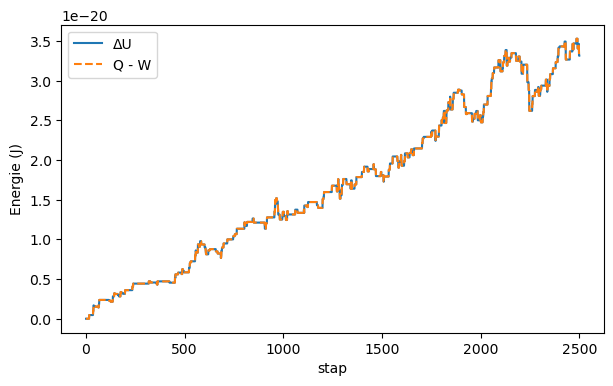

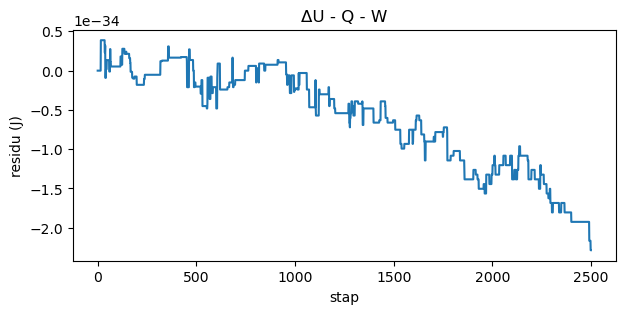

In [10]:
# Controle eerste hoofdwet: ΔU = Q - W  (met de tekenconventie van dit werkblad)

# Interne energie in 2D: U = N k_B T  (want per deeltje <E_kin> = k_B T)
U = N * k_B * temperatures
dU = U - U[0]

Q = heats - heats[0]
W = works - works[0]

rhs1 = Q - W
rhs2 = Q + W  # voor het geval W in de code als 'werk op het gas' is gedefinieerd

# Kies de beste match (na korte transiënt)
check_start = 200
err1 = np.mean(np.abs(dU[check_start:] - rhs1[check_start:]))
err2 = np.mean(np.abs(dU[check_start:] - rhs2[check_start:]))

print(f"gemiddelde |ΔU-(Q-W)|  = {err1:.3e} J")
print(f"gemiddelde |ΔU-(Q+W)|  = {err2:.3e} J")

best_rhs = rhs1 if err1 < err2 else rhs2
label_rhs = 'Q - W' if err1 < err2 else 'Q + W'

plt.figure(figsize=(7,4))
plt.plot(dU, label='ΔU')
plt.plot(best_rhs, '--', label=label_rhs)
plt.xlabel('stap')
plt.ylabel('Energie (J)')
plt.legend()
plt.show()

plt.figure(figsize=(7,3))
plt.plot(dU - best_rhs)
plt.xlabel('stap')
plt.ylabel('residu (J)')
plt.title('ΔU - ' + label_rhs)
plt.show()


In het boek wordt uitgelegd dat er maar twee vormen van energieoverdracht zijn van een systeem naar de omgeving. Dit kan via warmteoverdracht of via arbeid.
Bijzonder is dat deze beide grootheden alleen de snelheid van de moleculen beïnvloeden.
Toch zullen we in het volgende werkblad zien dat er een fundamenteel verschil zit in de werking van deze twee macroscopische grootheden. 

```{exercise}
Push je werk naar GitHub of ga door met de uitbreiding voor een beoordeling excellent.
```

```{exercise} 🌶 Uitbreiding
In bovenstaande simulatie zijn de onder- en bovenwand allebei een thermostaat die naar dezelfde temperatuur toewerken.
Als we die temperaturen verschillend maken, kunnen we kijken naar de thermische geleiding van het gas. 

- Maak nu een nieuwe simulatie met een volume met dezelfde breedte maar vier keer de hoogte, waarin de zuiger stilstaat. 
- Hou de dichtheid van de deeltjes hetzelfde, dus breid het aantal deeltjes uit naar 160. 
- Zet de temperatuur van de bovenwand op 150% en die van de onderwand op 50% van de starttemperatuur. 
- Door het warmtecontact via de bovenwand en de onderwand apart te rekenen, kan je zien hoeveel warmte er door het volume heenstroomt.
- Controller of deze warmtestroom evenredig is met het temperatuurverschil en omgekeerd evenredig met de afstand. (nogmaals: hou de dichtheid van de deeltjes constant)
- Geef de warmtegeleidingscoëfficiënt in W/K van het ideaalgas in je simulatie. (Opmerking: De warmtegeleidingscoëfficiënt wordt normaal gegeven in W/mK, maar in onze tweedimensionale simulatie valt de lengteafhankelijkheid er uit)
```

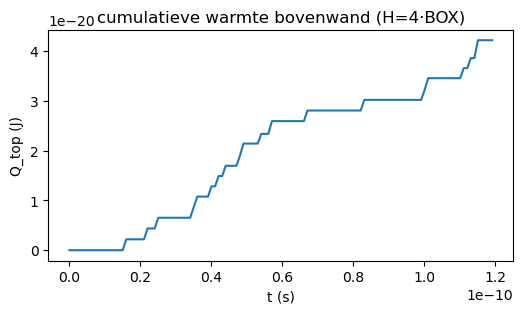

H=4: Qdot ≈ 3.712e-10 W,  κ_2D ≈ 9.898e-20 W/K


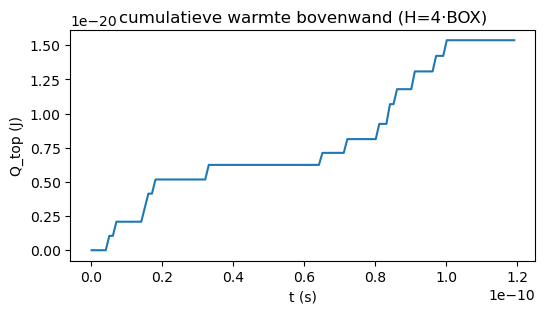

H=4, halve ΔT: Qdot ≈ 1.155e-10 W (verwacht ~0.5×)


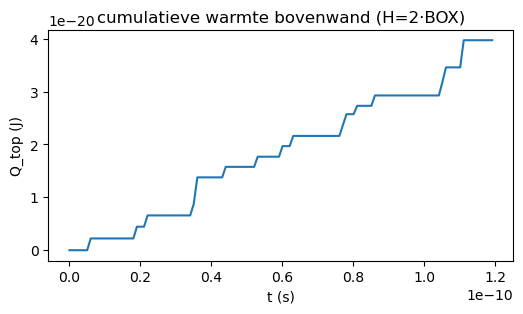

H=2: Qdot ≈ 3.284e-10 W (verwacht ~2× t.o.v. H=4)


In [11]:
# 🌶 Uitbreiding: thermische geleiding (tweedimensionaal)

# We maken een langwerpig volume (4x zo hoog), zonder zuigerbeweging.
# Bovenwand op 150% T0, onderwand op 50% T0. We meten de netto warmtestroom.

def run_conduction(height_factor=4, top_factor=1.5, bottom_factor=0.5, steps=3000, warmup=1000):
    global N, box_length, box_height, v_piston, pressure, work, heat, impulse_outward

    # Bewaar huidige instellingen (zodat je eventueel nog terug kunt)
    N_old = N
    box_length_old = box_length
    box_height_old = box_height
    v_piston_old = v_piston

    # Nieuwe geometrie en aantal deeltjes (dichtheid constant: area x4 => N x4)
    box_length = BOX_SIZE_0
    box_height = height_factor * BOX_SIZE_0
    N = int((20 if FAST_MODE else 40) * height_factor)  # bij factor 4 -> 80 (FAST) of 160 (volledig)
    if FAST_MODE:
            steps = min(steps, 1200)
            warmup = min(warmup, 400)

    v_piston = 0.0
    pressure = 0.0
    work = 0.0
    heat = 0.0
    impulse_outward = 0.0

    particles_local = []
    create_particles(particles_local)

    T_top = top_factor * temperature(particles_local)
    T_bottom = bottom_factor * temperature(particles_local)

    heat_top = 0.0
    heat_bottom = 0.0
    heat_top_hist = []
    t_hist = []
    t = 0.0

    def top_down_collision_split(particle: ParticleClass) -> None:
        nonlocal heat_top, heat_bottom
        global impulse_outward
        if abs(particle.r[1]) + particle.R > box_height / 2:
            is_top = particle.r[1] > 0
            T_wall = T_top if is_top else T_bottom

            temp_factor = (T_wall/temperature(particles_local)) if T_wall > 0 else 1.0
            particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)
            impulse_outward += abs(particle.momentum[1]) * (1 + temp_factor**0.5)

            dq = particle.kin_energy * (temp_factor - 1)
            if is_top:
                heat_top += dq
            else:
                heat_bottom += dq

            particle.v *= temp_factor**0.5
            particle.v[1] *= -1

    def handle_walls_split():
        global impulse_outward
        impulse_outward = 0.0
        for p in particles_local:
            # zijwanden zijn gewoon reflecterend (geen zuiger, geen werk)
            if abs(p.r[0]) + p.R > box_length / 2:
                p.r[0] = np.sign(p.r[0]) * (box_length/2 - p.R)
                impulse_outward += abs(p.momentum[0]) * 2
                p.v[0] *= -1
            top_down_collision_split(p)

    def step():
        for p in particles_local:
            p.update_position()
        handle_collisions(particles_local)
        handle_walls_split()

    for i in range(steps):
        step()
        t += DT
        if i % 10 == 0:
            heat_top_hist.append(heat_top)
            t_hist.append(t)

    # Warmtestroom schatten uit het lineaire deel na warmup
    idx_warm = max(0, warmup//10)  # omdat we elke 10 stappen loggen
    Qdot_top = (heat_top_hist[-1] - heat_top_hist[idx_warm]) / (t_hist[-1] - t_hist[idx_warm])

    deltaT = T_top - T_bottom
    kappa_2D = Qdot_top * box_height / deltaT  # Qdot = kappa * ΔT / L

    # Plot cumulatieve warmte van bovenwand
    plt.figure(figsize=(6,3))
    plt.plot(t_hist, heat_top_hist)
    plt.xlabel('t (s)')
    plt.ylabel('Q_top (J)')
    plt.title(f'cumulatieve warmte bovenwand (H={height_factor}·BOX)')
    plt.show()

    # Herstel oude instellingen
    N = N_old
    box_length = box_length_old
    box_height = box_height_old
    v_piston = v_piston_old

    return Qdot_top, kappa_2D, deltaT

# 1) basis (hoogte 4×, ΔT = T0)
Qdot4, kappa4, dT4 = run_conduction(height_factor=4, top_factor=1.5, bottom_factor=0.5)
print(f"H=4: Qdot ≈ {Qdot4:.3e} W,  κ_2D ≈ {kappa4:.3e} W/K")

# 2) controle: halve ΔT (zelfde hoogte)
Qdot4_half, kappa4_half, dT4_half = run_conduction(height_factor=4, top_factor=1.25, bottom_factor=0.75)
print(f"H=4, halve ΔT: Qdot ≈ {Qdot4_half:.3e} W (verwacht ~0.5×)")

# 3) controle: halve afstand (hoogte 2×, zelfde ΔT)
Qdot2, kappa2, dT2 = run_conduction(height_factor=2, top_factor=1.5, bottom_factor=0.5)
print(f"H=2: Qdot ≈ {Qdot2:.3e} W (verwacht ~2× t.o.v. H=4)")